## Проект: предсказание стоимости квартиры

Цель: минимизировать RMSE, используя данные macro.csv и train (1).csv

Есть этапы: загрузка данных, объединение с macro, создание новых признаков (возраст дома, отношения площадей, этажность, близость к метро/паркам).

Используются функции для удаления признаков (get_columns_to_drop), VarianceThreshold, удаление высококоррелированных признаков.

Категориальные признаки обработаны: label encoding для бинарных и порядковых, target encoding для sub_area.

Удалены выбросы по квантилям 0.05-0.95.

Созданы пайплайны для линейных моделей и CatBoost.

Проведён GridSearchCV для CatBoost.

Вычислены RMSE и MAPE.


In [1]:
import pandas as pd
import numpy as np

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

df1 = pd.read_csv('train (1).csv')
macro = pd.read_csv('macro.csv')

In [2]:
macro = macro.drop_duplicates(subset='timestamp')
df = df1.merge(macro, on='timestamp', how='left')

## Вещественные фичи

добавим возраст дома

In [3]:
df['build_year'] = pd.to_numeric(df['build_year'], errors='coerce')
df['year'] = pd.to_datetime(df['timestamp']).dt.year

df['house_age'] = df['year'] - df['build_year']

df.loc[df['house_age'] < 0, 'house_age'] = np.nan
df.loc[df['house_age'] > 200, 'house_age'] = np.nan
df['house_age'] = df['house_age'].fillna(df['house_age'].median())

добавим отношения площадей

In [4]:
df['life_sq_ratio'] = df['life_sq'] / df['full_sq'] 
df['kitch_sq_ratio'] = df['kitch_sq'] / df['full_sq']

добавим этажность

In [5]:
df['floor_first'] = (df['floor'] == 1).astype(int)
df['floor_last'] = (df['floor'] == df['max_floor']).astype(int)
df['floor_middle'] = ((df['floor'] > 1) & (df['floor'] < df['max_floor'])).astype(int)

добавим близость к метро и паркам

In [6]:
df['metro_within_1km'] = (df['metro_km_walk'] <= 1).astype(int)
df['park_within_2km'] = (df['park_km'] <= 2).astype(int)

 удаление неинформативных признаков и обработка пропусков

In [7]:
def get_columns_to_drop(df):
    km_cols = [col for col in df.columns if col.endswith('_km') 
               and not col.startswith(('metro_', 'park_', 'green_zone_', 'university_'))]

    count_cols = [col for col in df.columns if '_count' in col 
                  and not any(x in col for x in ['green_part', 'trc_', 'cafe_'])]
    
    price_cols = [col for col in df.columns if 'price_' in col and 'price_doc' not in col]
    
    sqm_cols = [col for col in df.columns if 'sqm' in col or '_5000' in col]

    people_cols = [col for col in df.columns if '_all' in col and 'full' not in col]
    
    male_cols = [col for col in df.columns if 'male' in col]

    manual_drop = ['id', 'school_quota', 'material']
    
    return km_cols + count_cols + price_cols + sqm_cols + people_cols + male_cols + manual_drop
cols_to_drop = get_columns_to_drop(df)
len(cols_to_drop)

df = df.drop(columns=cols_to_drop, errors='ignore')

In [8]:
df.head()

,timestamp,full_sq,life_sq,floor,max_floor,build_year,num_room,kitch_sq,state,product_type,sub_area,area_m,raion_popul,green_zone_part,indust_part,children_preschool,preschool_quota,preschool_education_centers_raion,children_school,school_education_centers_raion,school_education_centers_top_20_raion,hospital_beds_raion,healthcare_centers_raion,university_top_20_raion,sport_objects_raion,additional_education_raion,culture_objects_top_25,culture_objects_top_25_raion,shopping_centers_raion,office_raion,thermal_power_plant_raion,incineration_raion,oil_chemistry_raion,radiation_raion,railroad_terminal_raion,big_market_raion,nuclear_reactor_raion,detention_facility_raion,full_all,ID_metro,metro_min_avto,metro_km_avto,metro_min_walk,metro_km_walk,park_km,green_zone_km,railroad_station_walk_min,ID_railroad_station_walk,railroad_station_avto_min,ID_railroad_station_avto,public_transport_station_min_walk,water_1line,ID_big_road1,big_road1_1line,ID_big_road2,railroad_1line,ID_railroad_terminal,ID_bus_terminal,university_km,ecology,green_part_500,prom_part_500,trc_count_500,cafe_count_500,cafe_count_500_na_price,green_part_1000,prom_part_1000,trc_count_1000,cafe_count_1000,cafe_count_1000_na_price,green_part_1500,prom_part_1500,trc_count_1500,cafe_count_1500,cafe_count_1500_na_price,green_part_2000,prom_part_2000,trc_count_2000,cafe_count_2000,cafe_count_2000_na_price,green_part_3000,prom_part_3000,trc_count_3000,cafe_count_3000,cafe_count_3000_na_price,price_doc,oil_urals,gdp_quart,gdp_quart_growth,cpi,ppi,gdp_deflator,balance_trade,balance_trade_growth,usdrub,eurrub,brent,net_capital_export,gdp_annual,gdp_annual_growth,average_provision_of_build_contract,average_provision_of_build_contract_moscow,rts,micex,micex_rgbi_tr,micex_cbi_tr,deposits_value,deposits_growth,deposits_rate,mortgage_value,mortgage_growth,mortgage_rate,grp,grp_growth,income_per_cap,real_dispos_income_per_cap_growth,salary,salary_growth,fixed_basket,retail_trade_turnover,retail_trade_turnover_per_cap,retail_trade_turnover_growth,labor_force,unemployment,employment,invest_fixed_capital_per_cap,invest_fixed_assets,profitable_enterpr_share,unprofitable_enterpr_share,share_own_revenues,overdue_wages_per_cap,fin_res_per_cap,marriages_per_1000_cap,divorce_rate,construction_value,invest_fixed_assets_phys,pop_natural_increase,pop_migration,pop_total_inc,childbirth,mortality,water_pipes_share,baths_share,sewerage_share,gas_share,hot_water_share,electric_stove_share,heating_share,old_house_share,average_life_exp,infant_mortarity_per_1000_cap,perinatal_mort_per_1000_cap,incidence_population,load_of_teachers_preschool_per_teacher,child_on_acc_pre_school,load_of_teachers_school_per_teacher,students_state_oneshift,modern_education_share,old_education_build_share,provision_doctors,provision_nurse,load_on_doctors,power_clinics,hospital_beds_available_per_cap,hospital_bed_occupancy_per_year,turnover_catering_per_cap,theaters_viewers_per_1000_cap,seats_theather_rfmin_per_100000_cap,museum_visitis_per_100_cap,bandwidth_sports,population_reg_sports_share,students_reg_sports_share,apartment_build,year,house_age,life_sq_ratio,kitch_sq_ratio,floor_first,floor_last,floor_middle,metro_within_1km,park_within_2km
0,2011-08-20,43,27.0,4.0,NaN,NaN,NaN,NaN,NaN,Investment,Bibirevo,6.407578e+06,155572,0.189727,0.000070,9576,5001.0,5,10309,5,0,240.0,1,0,7,3,no,0,16,1,no,no,no,no,no,no,no,no,86206,1,2.590241,1.131260,13.575119,1.131260,2.158587,0.600973,65.038716,1.0,6.905893,1,3.299822,no,1,no,5,no,101,1,6.715026,good,0.00,0.00,0,0,0,7.36,0.00,3,19,1,14.27,6.92,9,34,1,11.77,15.97,19,36,1,11.98,13.55,23,68,5,5850000,109.31,14313.7,3.3,354.0,420.7,86.721,15.459,10.1,29.0048,41.7681,108.62,0.301811,46308.5,0.045037,5.76,6.74,1575.33,1438.74,131.16,204.78,10618898,0.009740,4.1,323275,1.051914,11.84,9948.7728,0.187791,42688.6,-0.005,44898.7,0.168917,12838.36,3322.047,286.952,106.6,6643.626,0.014,0.708,73976.19863,856.424079,0.708,0.292,0.891478,53636.0,226.214157,8.5,3.8,549075.8,106.6,1.1,5.1,6.2,10.8,9.7

удалим колонки с низкой дисперсией

In [9]:
from sklearn.feature_selection import VarianceThreshold

num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
if 'price_doc' in num_cols:
    num_cols.remove('price_doc')

df[num_cols] = df[num_cols].replace([np.inf, -np.inf], np.nan)
df[num_cols] = df[num_cols].fillna(df[num_cols].median())

selector = VarianceThreshold(threshold=0.01)
selector.fit(df[num_cols])

kept_cols = [num_cols[i] for i in range(len(num_cols)) if selector.get_support()[i]]
dropped_low_var = set(num_cols) - set(kept_cols)

df = df.drop(columns=dropped_low_var, errors='ignore')
print(f"Удалено признаков с низкой дисперсией: {len(dropped_low_var)}")

Удалено признаков с низкой дисперсией: 14


удалим колонки с высокой корреляцией

In [10]:
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
if 'price_doc' in num_cols:
    num_cols.remove('price_doc')


corr_matrix = df[num_cols].corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
high_corr = [col for col in upper.columns if any(upper[col] > 0.75)]

df = df.drop(columns=high_corr, errors='ignore')
print(f"Найдено {len(high_corr)} колонок с корреляцией >0.75")

Найдено 90 колонок с корреляцией >0.75


In [11]:
len(df.columns)

78

## Категориальные фичи

In [12]:
cat_features = df.select_dtypes(include=[object]).columns.tolist()
cat_features

['timestamp',
 'product_type',
 'sub_area',
 'culture_objects_top_25',
 'thermal_power_plant_raion',
 'incineration_raion',
 'oil_chemistry_raion',
 'radiation_raion',
 'railroad_terminal_raion',
 'big_market_raion',
 'nuclear_reactor_raion',
 'detention_facility_raion',
 'water_1line',
 'big_road1_1line',
 'railroad_1line',
 'ecology',
 'child_on_acc_pre_school',
 'modern_education_share',
 'old_education_build_share']

label encoding

In [13]:
df['culture_objects_top_25'] = df['culture_objects_top_25'].map({'yes': 1, 'no': 0})
df['water_1line'] = df['water_1line'].map({'yes': 1, 'no': 0})
df['railroad_1line'] = df['railroad_1line'].map({'yes': 1, 'no': 0})
df['big_road1_1line'] = df['big_road1_1line'].map({'yes': 1, 'no': 0})
df['ecology'] = df['ecology'].map({'poor': 1, 'satisfactory': 2, 'good': 3, 'excellent': 4, 'no data': 0})
df['product_type'] = df['product_type'].map({'Investment': 1, 'OwnerOccupier': 0})

удаляем неинформативные фичи

In [14]:
df = df.drop(columns=['child_on_acc_pre_school', 'modern_education_share', 'old_education_build_share'], errors='ignore')

cols_to_drop = [col for col in df.columns if '_raion' in col]
df = df.drop(columns=cols_to_drop,  errors='ignore')

target encoding для sub_area

In [15]:
def target_encoding_smooth(series, target, alpha=10):
    global_mean = target.mean()
    agg = target.groupby(series).agg(['count', 'mean'])
    smooth = (agg['count'] * agg['mean'] + alpha * global_mean) / (agg['count'] + alpha)
    return series.map(smooth)

df['sub_area_encoded'] = target_encoding_smooth(df['sub_area'], df['price_doc'], alpha=10) 

In [16]:
df = df.drop(columns=['timestamp', 'sub_area'])

In [17]:
df.head()

,full_sq,life_sq,floor,max_floor,build_year,num_room,kitch_sq,state,product_type,area_m,raion_popul,green_zone_part,indust_part,preschool_quota,culture_objects_top_25,full_all,ID_metro,metro_min_avto,green_zone_km,railroad_station_walk_min,ID_railroad_station_walk,ID_railroad_station_avto,public_transport_station_min_walk,water_1line,ID_big_road1,big_road1_1line,ID_big_road2,railroad_1line,ID_railroad_terminal,ID_bus_terminal,university_km,ecology,green_part_500,prom_part_500,trc_count_500,prom_part_1000,price_doc,oil_urals,gdp_quart,gdp_quart_growth,balance_trade,balance_trade_growth,net_capital_export,average_provision_of_build_contract,average_provision_of_build_contract_moscow,micex,mortgage_value,income_per_cap,overdue_wages_per_cap,water_pipes_share,house_age,life_sq_ratio,floor_first,floor_last,floor_middle,metro_within_1km,park_within_2km,sub_area_encoded
0,43,27.0,4.0,12.0,1979.0,2.0,6.0,2.0,1,6.407578e+06,155572,0.189727,0.000070,5001.0,0,86206,1,2.590241,0.600973,65.038716,1.0,1,3.299822,0,1,0,5,0,101,1,6.715026,3,0.00,0.00,0,0.00,5850000,109.31,14313.7,3.3,15.459,10.1,0.301811,5.76,6.74,1438.74,323275,42688.6,53636.0,99.9,35.0,0.627907,0,0,0,0,0,6.689046e+06
1,34,19.0,3.0,12.0,1979.0,2.0,6.0,2.0,1,9.589337e+06,115352,0.372602,0.049637,3119.0,1,76284,2,0.936700,0.065321,40.943917,2.0,2,0.783160,0,2,0,4,0,32,2,1.852560,4,25.14,0.00,0,0.07,6000000,109.31,14313.7,3.3,15.459,10.1,0.301811,5.76,6.74,1444.11,323275,42688.6,53636.0,99.9,35.0,0.558824,0,0,0,1,1,8.354868e+06
2,43,29.0,2.0,12.0,1979.0,2.0,6.0,2.0,1,4.808270e+06,101708,0.112560,0.118537,1463.0,0,101982,3,2.120999,0.453172,15.331896,3.0,3,3.945073,0,3,0,4,0,5,3,0.841254,1,1.67,0.00,0,0.29,5700000,109.31,14313.7,3.3,15.459,10.1,0.301811,5.76,6.74,1458.84,323275,42688.6,53636.0,99.9,35.0,0.674419,0,0,0,0,1,6.621883e+06
3,89,50.0,9.0,12.0,1979.0,2.0,6.0,2.0,1,1.258354e+07,178473,0.194703,0.069753,6839.0,0,21155,4,1.489049,0.106125,51.497190,4.0,4,1.579164,0,1,0,17,0,83,1,10.903161,3,17.36,0.57,0,10.35,13100000,111.29,14313.7,3.3,15.386,10.1,0.599709,5.76,6.74,1551.58,386388,40311.3,53636.0,99.9,35.0,0.561798,0,0,0,1,1,8.785144e+06
4,77,77.0,4.0,12.0,1979.0,2.0,6.0,2.0,1,8.398461e+06,108171,0.015234,0.037316,3240.0,0,28179,5,1.257186,0.236214,10.247521,5.0,113,0.857764,0,4,0,10,1,113,4,0.991683,4,3.56,4.44,1,8.29,16331452,111.29,14313.7,3.3,15.386,10.1,0.599709,5.76,6.74,1492.83,386388,40311.3,53636.0,99.9,35.0,1.000000,0,0,0,1,1,1.117432e+07


## Моделирование и оценка

уберем верхний и нижний квантиль

In [18]:
top_quantile = df['price_doc'].quantile(0.95)
low_quantile = df['price_doc'].quantile(0.05)
df_new = df[(df['price_doc'] > low_quantile) & (df['price_doc'] < top_quantile)]

<Axes: ylabel='price_doc'>

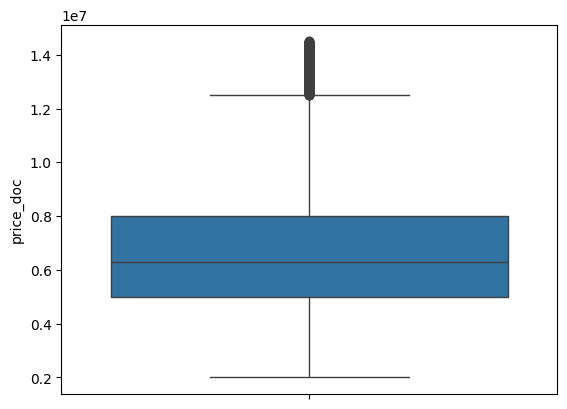

In [19]:
import seaborn as sns
sns.boxplot(df_new['price_doc'])

In [20]:
from sklearn.model_selection import train_test_split
X = df_new.drop('price_doc', axis=1)
y = df_new['price_doc']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

создаем пайплайны

In [22]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso, Ridge
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostRegressor

scaler = StandardScaler()

pipe_lr = Pipeline([
    ('scaler', scaler),
    ('lr', LinearRegression())
])

pipe_lasso = Pipeline([
    ('scaler', scaler),
    ('lasso', Lasso(alpha=0.0001))
])

pipe_ridge = Pipeline([
    ('scaler', scaler),
    ('ridge', Ridge(alpha=0.0001))
])

pipe_cb = Pipeline(steps=[
    ('scaler', scaler),
    ('cb', CatBoostRegressor(verbose=0, random_seed=42))
])

обучение и предсказание

In [23]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

results = {}

pipe_lr.fit(X_train, y_train)
y_pred_lr = pipe_lr.predict(X_test)
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
results['Linear Regression'] = rmse_lr

pipe_lasso.fit(X_train, y_train)
y_pred_lasso = pipe_lasso.predict(X_test)
rmse_lasso = np.sqrt(mean_squared_error(y_test, y_pred_lasso))
results['Lasso (alpha=0.001)'] = rmse_lasso

pipe_ridge.fit(X_train, y_train)
y_pred_ridge = pipe_ridge.predict(X_test)
rmse_ridge = np.sqrt(mean_squared_error(y_test, y_pred_ridge))
results['Ridge (alpha=0.001)'] = rmse_ridge

param_grid = {
    'cb__depth': [4, 6, 8],
    'cb__learning_rate': [0.01, 0.05, 0.1],
    'cb__iterations': [500, 1000]
}
grid = GridSearchCV(pipe_cb, param_grid, cv=3, scoring='neg_root_mean_squared_error', n_jobs=-1)
grid.fit(X_train, y_train)
print("Best params:", grid.best_params_)
best_cb = grid.best_estimator_
y_pred_best = best_cb.predict(X_test)



Best params: {'cb__depth': 8, 'cb__iterations': 1000, 'cb__learning_rate': 0.05}


In [25]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

results = {}
for name, y_pred in zip(['Linear', 'Lasso', 'Ridge'],
                         [y_pred_lr, y_pred_lasso, y_pred_ridge]):
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mape_val = mape(y_test, y_pred)
    results[name] = {'RMSE': rmse, 'MAPE': mape_val}
    print(f"{name}: RMSE = {rmse:,.0f} руб., MAPE = {mape_val:.2f}%")
    
    
rmse_cb = np.sqrt(mean_squared_error(y_test, y_pred_best))
mape_cb = mape(y_test, y_pred_best)
print(f"Best CatBoost RMSE: {rmse_cb:,.0f} руб., MAPE = {mape_cb:.2f}%")

Linear: RMSE = 1,667,392 руб., MAPE = 20.02%
Lasso: RMSE = 1,667,392 руб., MAPE = 20.02%
Ridge: RMSE = 1,667,392 руб., MAPE = 20.02%
Best CatBoost RMSE: 1,202,667 руб., MAPE = 12.26%


оценим самые важные фичи

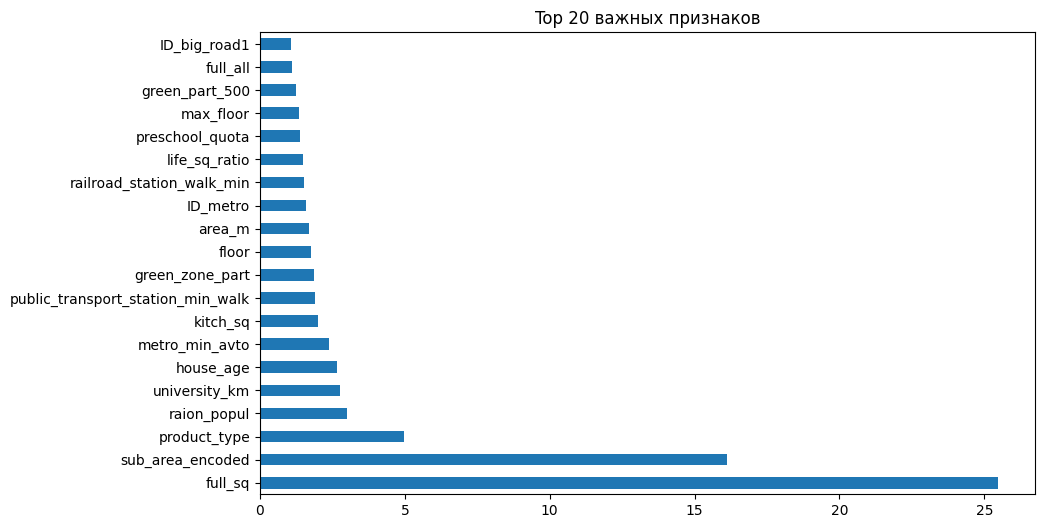

In [26]:
import matplotlib.pyplot as plt
feature_importance = best_cb.named_steps['cb'].feature_importances_
feat_imp = pd.Series(feature_importance, index=X_train.columns).sort_values(ascending=False)
feat_imp.head(20).plot(kind='barh', figsize=(10,6))
plt.title('Top 20 важных признаков')
plt.show()

то есть решающие - площадь квартиры, в каком районе находится, тип имущества, население района и близость к инфраструктуре - метро, университетам, остановкам общественного транспорта

## Итоговая оценка модели

Итоговый RMSE: 1,202,667 руб., MAPE = 12.26%

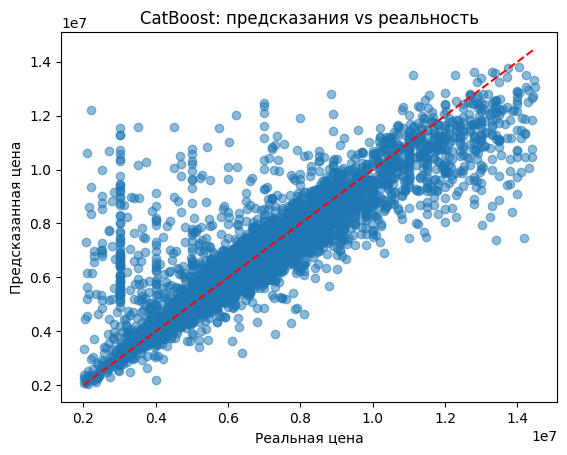

In [27]:
plt.scatter(y_test, y_pred_best, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Реальная цена')
plt.ylabel('Предсказанная цена')
plt.title('CatBoost: предсказания vs реальность')
plt.show()